### add more dimensions

in the simple bigram model our letters just had an integer index

this time lets say they inhabit a 2 dimensional space, and we can move them around in that space as we train

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn

a 2D plane is a good start for us to gain some intuitions

In [2]:
vocab_size = 27
embedding_size = 2
# our embedding space
es = torch.randn((vocab_size, embedding_size))

## character embedding in 2D

we our 27x2 tensor to represent the characters

again the mapping from character to embedding is simple

* a -> is the tensor at es[1]
* b -> is the tensor at es[1]

In [3]:
print('a', es[1])
print('b', es[2])

a tensor([-0.3800, -1.8813])
b tensor([-0.8908,  0.1852])


initially these positions are random, they have no learned attributes

Will they 'learn' something - if they do then that's pretty encouraging (spoiler they do)

### Run through getting batches again

we wrap this up in a lib file soon

In [4]:
with open("../resources/names.txt", "r") as r:
    names = ["." + f + "." for f in r.read().split()]

import string
letters = [l for l in string.ascii_lowercase]

itos = {0: "."}
stoi = {".": 0}

for i, l in enumerate(letters):
    offset = i+1
    stoi[l] = offset
    itos[offset] = l


In [5]:
from random import randrange

names_length = len(names)

def sample_names(size=5):
    batch_names = []
    for i in range(size):
        ni = randrange(names_length-1)
        name = names[ni]
        batch_names.append(name)
    return batch_names

sample_names(2)

['.tessie.', '.roland.']

In [6]:
def get_xys(samples):
    xs, ys = [], []
    for s in samples:
        em = [stoi[c] for c in s] 
        for x, y in zip(em, em[1:]):
            xs.append(x)
            ys.append(y)

    return xs, ys

train = get_xys(names)

### Weights for the embedding

Our weights look pretty different this time: remember before we just used a 27x27 tensor.

Now our input tensor is 27x2 so we want a weights vector of shape 2x_ where _ is the number of neurons in our layer

### Neurons 

In our simple bigram model we didn't really think of the weights in terms of neurons and activations.

Now we have our 2D representation of characters our network looks pretty different.

Our neurons also have a new bias term (not the other bias in ML as in bias and variance) 

combined this is a Linear layer, it's a tensor of linear equations (y1 = x1 + b1, y2 = x2 + b2, etc

so for a 10 neuron linear layer to act on our 2D embeddings we get:

In [7]:
embedding_size = 2
num_neurons = 10

W = torch.randn(embedding_size, num_neurons)
b = torch.randn(num_neurons)

## so we could show these

by taking 2 'x' inputs and getting 'y' outputs we'll be able to plot 5 lines

In [8]:
linspace1  = torch.tensor([1,2], dtype=torch.float)

linspace2 = linspace1 @ W + b

linspace2, linspace2[0].data.item()

(tensor([ 1.1892, -2.8741,  0.6369, -0.1159,  1.3788, -2.6454, -3.4522, -0.3040,
          0.7521,  2.3771]),
 1.1891674995422363)

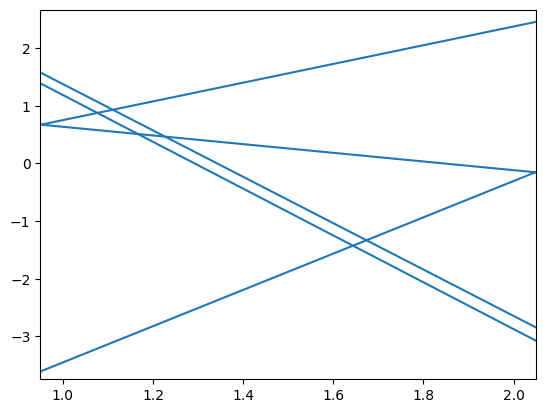

In [9]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.axline((1, linspace2[i*2].data.item()), (2, linspace2[i*2+1].data.item()))

Not very informative but...

### Anyway onto the non-linearity

these 'shape' the output of our linear layer and increase the networks ability to learn a more complex fit to the data

#### and lets get some training data

our train above has characters and their training labels, we need to get the embeddings for these from the embedding space (es above)

lets start with 20 examples

In [10]:
example_size = 20
embedded = es[train[0][:example_size]]

In [11]:
outputL1 = torch.tanh(embedded @ W + b)
outputL1.shape

torch.Size([20, 10])

### how do we compare to our labels

we'll need to map back to something that looks like our vocab so we can generate a loss

we do this simply with another linear layer of output size: vocab_size

In [12]:
W2 = torch.randn(num_neurons, vocab_size)
b2 = torch.randn(vocab_size)

In [13]:
logits = outputL1 @ W2 + b2
logits.shape

torch.Size([20, 27])

### so we've put 20 inputs through the network and we wantto compare with our prediction labels

our logits are non normalized probabilites for our labels

they're now in the same 'space' as our labels and we'll be able to calculate the difference between what the network has picked out as 
the next likely character and the real next character

In [14]:
labels = train[1][:example_size]
labels

[5, 13, 13, 1, 0, 15, 12, 9, 22, 9, 1, 0, 1, 22, 1, 0, 9, 19, 1, 2]

### Counts Probabilities

first we generate counts by taking the exp() of our logits

this also ensures we have all positive probabilities

for each x we can look at the probablities

lets look at the first character input and print out the probabilities, the top probability and the position of that probability

In [17]:
first_counts = logits[0].exp()
top_prob = first_counts.max()
prediction = torch.nonzero(first_counts == top_prob, as_tuple=True)[0].item()
first_counts, top_prob, itos[prediction]

(tensor([3.0321e-01, 2.5420e-02, 2.2236e+00, 4.4441e+00, 6.2367e-01, 1.3042e+02,
         2.1561e+00, 1.4782e+02, 6.1671e+01, 5.2812e-03, 5.7924e+00, 1.3263e+00,
         3.2467e+01, 5.8708e+01, 1.7662e-02, 3.3966e+00, 1.9100e+00, 3.1831e-01,
         1.1187e+00, 6.6565e-01, 2.8459e-02, 6.7151e-02, 1.3049e+00, 8.3640e-01,
         7.0611e+00, 3.3212e-01, 9.3277e+00]),
 tensor(147.8236),
 'g')

### cross entropy

we predict a bunch of probabilites and so end up with what we think is a possible distribution 

we want the difference between this and the real values from our labels so we find a cross entropy loss from all our losses

In [18]:
counts = logits.exp()

# normalize our counts
prob = counts / counts.sum(1, keepdims=True)

# this just picks out the prediction value for each label
total_loss = -prob[torch.arange(example_size), labels].log()

loss = total_loss.mean()

loss

tensor(7.7730)

## OK lets set things up for a real run

we create our embeddings, a first linear layer which we'll use with a non-linearity, and a second linear layer to project back to our vocab labels

In [20]:
es = torch.randn((27, 2), requires_grad=True)
W = torch.randn((2, 100), requires_grad=True)
b = torch.randn(100, requires_grad=True)
W2 = torch.randn((100, 27), requires_grad=True)
b2 = torch.randn(27, requires_grad=True)

parameters = [es, W, b, W2, b2]

## OK lets run this and see what happens...

when we run our system we'll calculate a loss over all our training examples at once

we'll shortcut the softmax calculations and push everything into torch's cross_entropy loss function

F.cross_entropy does exactly the same thing but optimized

In [21]:
names_length = len(names)
epochs = 70
batch_size = 300
learning_rate = 2
samples = 1000 #in future we want our epoch to roughly sample everything - names_length / batch_size

In [22]:
for ep in range(epochs):
    epoch_loss = 0
    for s in range(samples):
        x, y = get_xys(sample_names(batch_size))
        Y = torch.tensor(y)
        train = es[x]
        outputL1 = torch.tanh(train @ W + b)
        logits = outputL1 @ W2 + b2

        loss = F.cross_entropy(logits, Y)

        epoch_loss += loss

        es.grad = None
        W.grad = None
        b.grad = None
        W2.grad = None
        b2.grad = None
        
        loss.backward()
        es.data -=learning_rate * es.grad
        W.data -= learning_rate * W.grad
        b.data -= learning_rate * b.grad
        W2.data -= learning_rate * W2.grad
        b2.data -= learning_rate * b2.grad
    learning_rate *= .95

    if ep % 10 == 0:
        print(epoch_loss/samples)
        print(ep, learning_rate)

tensor(7.1752, grad_fn=<DivBackward0>)
0 1.9
tensor(2.4704, grad_fn=<DivBackward0>)
10 1.1376001845529191
tensor(2.4633, grad_fn=<DivBackward0>)
20 0.6811232525762293
tensor(2.4603, grad_fn=<DivBackward0>)
30 0.40781365149158066
tensor(2.4588, grad_fn=<DivBackward0>)
40 0.24417309747369587
tensor(2.4584, grad_fn=<DivBackward0>)
50 0.14619545302575496
tensor(2.4571, grad_fn=<DivBackward0>)
60 0.08753261807520867


In [23]:
def generate_names(num_names):
    for i in range(num_names):
        out = []
        ix = 0
        for nl in range(20):
            xenc = es[ix]
            
            outputL1 = torch.tanh(xenc @ W + b)
            logits = outputL1 @ W2 + b2
            
            counts = logits.exp()
            
            p = counts / counts.sum(0, keepdim=True)
    
            ## torch.multinomial pulls out an index in p (num_samples=1) by sampling from the elements in p according to their probabilities 
            ## (p is normalized in the softmax above)
            ix = torch.multinomial(p, num_samples=1).item()
    
            if ix == 0:
                break
            out.append(itos[ix])
            
        print("".join(out))

In [24]:
generate_names(10)

sa
a
ryloe
jaaberyaxsinoel
sabeti
ida
ssilesibyn
ch
a
kilakimaari


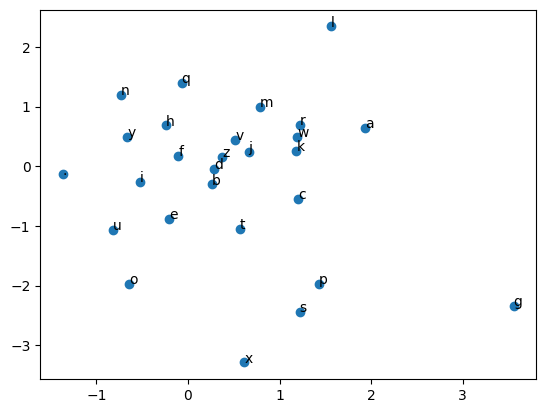

In [25]:
x = es.T[0].tolist()
y = es.T[1].tolist()
n = ['.'] + letters

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]))

## Not very impressive

our network got more powerful but we didn't really learn anything more than the other models

we're still just trying to predict one letter given the preceeding letter and there's no more information available in our
new system - in the next part we'll add [sequences](../sequences) of input characters to predict outputs